# Notebook Title and Introduction
This notebook is designed to clean, process, and analyze train operation data
It includes data validation, formatting corrections, feature engineering, and data visualization

# Load libraries

import pandas as pd

Imports the Pandas library for efficiently manipulating data frames.
import numpy as np

Imports NumPy for numeric operations and handling missing values ​​(np.nan).
import seaborn as sns

Imports Seaborn, a visualization library based on Matplotlib, for creating elegant statistical graphs.
import matplotlib.pyplot as plt

Imports Pyplot (from Matplotlib), used to display and customize graphs.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset and remove duplicates

Loads a CSV file named dataset.csv using a semicolon (;) as a separator and stores the contents in a DataFrame named data.

Removes duplicates by keeping only the last occurrence of each identical row, then creates an independent copy of the DataFrame to prevent accidental changes to the original.

In [36]:
data = pd.read_csv("dataset.csv", sep=";")
data_clean = data.drop_duplicates(subset=["Date", "Departure station", "Arrival station"], keep='first').copy()

# Data Cleaning Functions

convert_type_int(data, column) → Converts a column to integer values, replacing invalid or out-of-range values with -1.

change_timedelta(data, column) → Converts a column to timedelta format (in minutes), replacing invalid values with -1.

replace_null(data) → Replaces various null values across key columns with consistent placeholder text.

pct_2_float(data, column) → Validates percentage columns, converts to float, clips invalid values, and rounds to two decimals.

check_date_format(data) → Ensures correct date formatting, replacing missing or invalid values with the closest valid date.

replace_in_dash(data) → Fixes incorrect date formats, replacing non-numeric separators with dashes (-) for consistency.

In [37]:
def convert_type_int(data, column):
    """Converts a column to integer values, replacing invalid or out-of-range values with -1."""
    data[column] = pd.to_numeric(data[column], errors='coerce').fillna(-1).round().astype(int)
    data.loc[(data[column] > 1000), column] = -1.0

def change_timedelta(data, column):
    """Converts a column to timedelta format (in minutes), replacing invalid values with -1."""
    data[column] = pd.to_timedelta(data[column], unit='m', errors='coerce').fillna(-1)

def change_float_time(data, column):
    """
    Converts a column to float (in minutes), rounded to 2 decimals.
    Replaces non-numeric values or values outside [0, 1440] with -1.
    """
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data[column] = data[column].where((data[column] >= 0) & (data[column] <= 1440), np.nan)
    data[column] = data[column].fillna(-1).round(2)

def replace_null(data):
    """Replaces various null values across key columns with consistent placeholder text."""
    data['Service'] = data['Service'].replace([None, np.nan, 'N/A', 'NA'], 'Inconnu')
    data["Departure station"] = data["Departure station"].replace([None, np.nan, 'N/A', 'NA'], 'No information about the departure station')
    data["Arrival station"] = data["Arrival station"].replace([None, np.nan, 'N/A', 'NA'], 'No information about the arrival station')
    data['Cancellation comments'] = data['Cancellation comments'].replace(
        [None, np.nan, 'N/A', 'NA'], "Aucune information à propos de l’annulation de ce train.")
    data['Departure delay comments'] = data['Departure delay comments'].replace(
        [None, np.nan, 'N/A', 'NA'], "Aucune information à propos du retard de ce train au départ.")
    data['Arrival delay comments'] = data['Arrival delay comments'].replace(
        [None, np.nan, 'N/A', 'NA'], "Aucune information à propos du retard de ce train à l’arriver.")
    data['Pct delay due to external causes'] = data['Pct delay due to external causes'].replace([None, np.nan, 'N/A', 'NA'], -1)
    data['Pct delay due to infrastructure'] = data['Pct delay due to infrastructure'].replace([None, np.nan, 'N/A', 'NA'], -1)
    data['Pct delay due to traffic management'] = data['Pct delay due to traffic management'].replace([None, np.nan, 'N/A', 'NA'], -1)
    data['Pct delay due to rolling stock'] = data['Pct delay due to rolling stock'].replace([None, np.nan, 'N/A', 'NA'], -1)
    data['Pct delay due to station management and equipment reuse'] = data['Pct delay due to station management and equipment reuse'].replace([None, np.nan, 'N/A', 'NA'], -1)
    data['Pct delay due to passenger handling (crowding, disabled persons, connections)'] = data['Pct delay due to passenger handling (crowding, disabled persons, connections)'].replace([None, np.nan, 'N/A', 'NA'], -1)

def pct_2_float(data, column):
    """Validates percentage columns: converts to float, clips invalid values, and rounds to 2 decimals."""
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data.loc[(data[column] < 0) | (data[column] > 100), column] = -1.0
    data[column] = data[column].round(2)

def replace_in_dash(data):
    first_col = data.columns[0]
    fixed_dates = np.where(
        data[first_col].astype(str).str.match(r'^\d{4}[^0-9]\d{2}$'),
        data[first_col].astype(str).str.replace(r'[^0-9]', '-', regex=True),
        data[first_col]
    )
    data[first_col] = fixed_dates
    return data


def check_date_format(data):
    if "Date" not in data.columns:
        print("Colonne 'Date' non trouvée")
        return data
    data["Date"] = data["Date"].replace(r'^\s*$', np.nan, regex=True)
    data["Date"] = pd.to_datetime(data["Date"], errors='coerce')
    data["Date"] = data["Date"].ffill()
    data["Date"] = data["Date"].dt.to_period('M').astype(str)
    return data


# Apply date format cleaning
Applies the date validation function to the cleaned DataFrame to correct inconsistent formats and years.

Converts the "Date" column to datetime objects, replacing invalid formats with NaT.

Transforms dates into monthly periods (YYYY-MM), and replaces missing values ​​with "No date info.

In [38]:
replace_in_dash(data_clean)
check_date_format(data_clean)
replace_null(data_clean)
data_clean["Date"] = pd.to_datetime(data_clean["Date"], errors='coerce').dt.strftime("%Y-%m")
data_clean = data_clean[
    (pd.to_datetime(data_clean["Date"], errors='coerce') >= pd.to_datetime("2018-01-01")) &
    (pd.to_datetime(data_clean["Date"], errors='coerce') <= pd.to_datetime("2024-12-31"))]

# Apply cleaning functions to numerical and time columns

List of numeric columns to convert to integers (e.g., number of scheduled, canceled, or delayed trains).

Loop through these columns to apply a cleanup: convert to integers and process abnormal values.

List of columns representing durations (e.g., average travel time or delay).

Loop through these columns to convert them to timedelta objects, with error handling.

In [39]:
columns_int = [
    "Number of scheduled trains", "Number of cancelled trains",
    "Number of trains delayed at departure", "Number of trains delayed at arrival",
    "Number of trains delayed > 15min", "Average delay of trains > 15min (if competing with flights)",
    "Number of trains delayed > 30min", "Number of trains delayed > 60min"
]
for col in columns_int:
    convert_type_int(data_clean, col)

time_columns = [
    'Average journey time', 'Average delay of late trains at departure',
    'Average delay of all trains at departure', 'Average delay of late trains at arrival',
    'Average delay of all trains at arrival'
]
for col in time_columns:
    change_float_time(data_clean, col)

# Handle null and invalid values

Replaces missing values ​​in key columns with meaningful text (avoids NaN or "N/A").

List of columns containing percentages related to delay causes (infrastructure, equipment, etc.).

Loops through these columns to convert values ​​to float, correct values ​​outside the range [0–100], and round to 2 decimal places.

In [40]:
replace_null(data_clean)

pct_columns = [
    'Pct delay due to external causes', 'Pct delay due to infrastructure',
    'Pct delay due to traffic management', 'Pct delay due to rolling stock',
    'Pct delay due to station management and equipment reuse',
    'Pct delay due to passenger handling (crowding, disabled persons, connections)'
]
for col in pct_columns:
    pct_2_float(data_clean, col)
data_clean = data_clean[
    (data_clean["Departure station"] != "No information about the departure station") &
    (data_clean["Arrival station"] != "No information about the arrival station")
]

# Fix inconsistent station names
Loads the list of reference stations from stations_sncf.csv and converts it into a set of unique names without extra spaces.

Calculates a simple similarity distance between two names (number of different characters), used to detect typos.

Returns the closest reference station name (if the distance is ≤ 3), or None if there is no acceptable match.

Merges the departure and arrival station names from the dataset to identify those to check.

For each unknown station, suggests a correction from the reference stations and builds a replacement dictionary.

Replaces incorrect names in the "Departure station" and "Arrival station" columns with their corrected equivalents.

In [41]:
reference_stations = set(
    pd.read_csv("stations_sncf.csv")["LIBELLE"].dropna().str.strip().unique()
)

def compute_string_distance(name1, name2):
    name1, name2 = name1.lower(), name2.lower()
    if abs(len(name1) - len(name2)) > 3:
        return 84
    min_len = min(len(name1), len(name2))
    diff = sum(c1 != c2 for c1, c2 in zip(name1[:min_len], name2[:min_len]))
    diff += abs(len(name1) - len(name2))
    return diff

def suggest_station_name(unknown, reference_set, max_distance=3):
    candidates = [(station, compute_string_distance(unknown, station)) for station in reference_set]
    close_matches = [station for station, dist in candidates if dist <= max_distance]
    if close_matches:
        return sorted(close_matches, key=lambda current: compute_string_distance(unknown, current))[0]
    return None

stations_to_check = pd.concat([
    data_clean["Departure station"].dropna().str.strip(),
    data_clean["Arrival station"].dropna().str.strip()
]).unique()

replacement_dict = {}
for station in stations_to_check:
    if station not in reference_stations:
        suggestion = suggest_station_name(station, reference_stations)
        if suggestion:
            replacement_dict[station] = suggestion

data_clean["Departure station"] = data_clean["Departure station"].str.strip().replace(replacement_dict)
data_clean["Arrival station"] = data_clean["Arrival station"].str.strip().replace(replacement_dict)


# Logical validation of delay hierarchy

Iterates through each row of the dataset to check the consistency of delays:

-Checks that the number of trains delayed by >15 minutes is greater than those delayed by >30 minutes.

-Checks that those delayed by >30 minutes are greater than those delayed by >60 minutes.

-If not, the inconsistent value is replaced by -1.

Apply the function to the cleaned DataFrame.

In [42]:
def check_time_delay_train(data_clean):
    for i in data_clean.index:
        d15 = data_clean.at[i, "Number of trains delayed > 15min"]
        d30 = data_clean.at[i, "Number of trains delayed > 30min"]
        d60 = data_clean.at[i, "Number of trains delayed > 60min"]
        if not (d15 > d30):
            data_clean.at[i, "Number of trains delayed > 15min"] = -1
        if not (d30 > d60):
            data_clean.at[i, "Number of trains delayed > 30min"] = -1

check_time_delay_train(data_clean)

# Correct service type based on station data

List of valid service types expected (national or international train).

Loads the stations_sncf.csv file, which contains the stations and their service types.

Creates a dictionary associating each station (LABEL) with its service (SERVICE).

Function that:

-Checks if the Service value is already correct,

-Otherwise, deduces the correct service type based on the departure/arrival stations.

Corrects the "Service" column for each row of the dataset according to the defined logic.

In [43]:
valid_services = ["National", "International"]
ref_df = pd.read_csv("stations_sncf.csv", sep=",")
station_service_map = dict(zip(ref_df["LIBELLE"], ref_df["SERVICE"]))

def recover_correct_service(row):
    service_base = str(row["Service"])
    if service_base in valid_services:
        return service_base
    service_depart = station_service_map.get(row["Departure station"])
    service_arrive = station_service_map.get(row["Arrival station"])
    return "International" if (service_depart == "International" or service_arrive == "International") else "National"

data_clean["Service"] = data_clean.apply(recover_correct_service, axis=1)

# Feature engineering

Calculation of the new columns:

- "Number of active trains": Number of trains actually running (planned − canceled).

- "PCT Arrival Delay Rate": Percentage of trains arriving late among active trains.

- "PCT Cancel": Percentage of canceled trains out of the planned total.

- "Severe Delay Rate": Percentage of trains delayed by more than 15 minutes among active trains.

Replace invalid values ​​(≤ 0) in the calculated columns with -1.

Apply the validation function to each column created.

Rounds percentages to 2 decimal places for better readability.

In [44]:
#NUMBER TRAIN ACTIVE
data_clean["Number train active"] = np.where((data_clean["Number of scheduled trains"] == -1) | (data_clean["Number of cancelled trains"] == -1), -1, data_clean["Number of scheduled trains"] - data_clean["Number of cancelled trains"])
data_clean.loc[data_clean["Number train active"] <= 0, "Number train active"] = -1
#PCT CANCEL
data_clean["Pct cancel"] = np.where((data_clean["Number of scheduled trains"] == -1) | (data_clean["Number of cancelled trains"] == -1) | (data_clean["Number of scheduled trains"] == 0), -1,(data_clean["Number of cancelled trains"] / data_clean["Number of scheduled trains"]) * 100)
data_clean.loc[data_clean["Pct cancel"] > 100, "Pct cancel"] = -1
#PCT DEPART DELAY RATE
data_clean["Pct depart delay rate"] = np.where((data_clean["Number of trains delayed at departure"] == -1) | (data_clean["Number train active"] <= 0), -1, (data_clean["Number of trains delayed at departure"] / data_clean["Number train active"]) * 100)
data_clean.loc[data_clean["Pct depart delay rate"] > 100, "Pct depart delay rate"] = -1
#PCT ARRIVAL DELAY RATE
data_clean["Pct arrival delay rate"] = np.where((data_clean["Number of trains delayed at arrival"] == -1) | (data_clean["Number train active"] <= 0), -1, (data_clean["Number of trains delayed at arrival"] / data_clean["Number train active"]) * 100)
data_clean.loc[data_clean["Pct arrival delay rate"] > 100, "Pct arrival delay rate"] = -1
##SEVERAL DELAY AND MAIN CAUSE
data_clean["Severe delay rate"] = np.where((data_clean["Number of trains delayed > 15min"] == -1) | (data_clean["Number train active"] <= 0), -1, (data_clean["Number of trains delayed > 15min"] / data_clean["Number train active"]) * 100)
data_clean.loc[data_clean["Severe delay rate"] > 100, "Severe delay rate"] = -1

data_clean["Main cause"] = ""

def check_feature_column(data, value):
    for i in data.index:
        if not data.at[i, value] > 0:
            data.at[i, value] = -1

def create_main_column(data):
    cause_cols = [
    "Pct delay due to external causes",
    "Pct delay due to infrastructure",
    "Pct delay due to traffic management",
    "Pct delay due to rolling stock",
    "Pct delay due to station management and equipment reuse",
    "Pct delay due to passenger handling (crowding, disabled persons, connections)"
    ]
    data_clean["Main cause"] = data[cause_cols].idxmax(axis=1)

for col in ["Number train active", "Pct arrival delay rate", "Pct cancel", "Severe delay rate", "Pct depart delay rate"]:
    check_feature_column(data_clean, col)

data_clean[["Pct depart delay rate", "Pct arrival delay rate", "Pct cancel", "Severe delay rate"]] = data_clean[["Pct depart delay rate", "Pct arrival delay rate", "Pct cancel", "Severe delay rate"]].round(2)
create_main_column(data_clean)

# Save cleaned dataset

Exports the cleaned DataFrame to a new CSV file named cleaned_dataset.csv, without including row indexes.

In [45]:
data_clean.to_csv("cleaned_dataset.csv", index=False)

# Visualizations

This section presents a visual exploration of the cleaned dataset to uncover key trends, patterns, and insights about train operations.

# Number of active trains per month

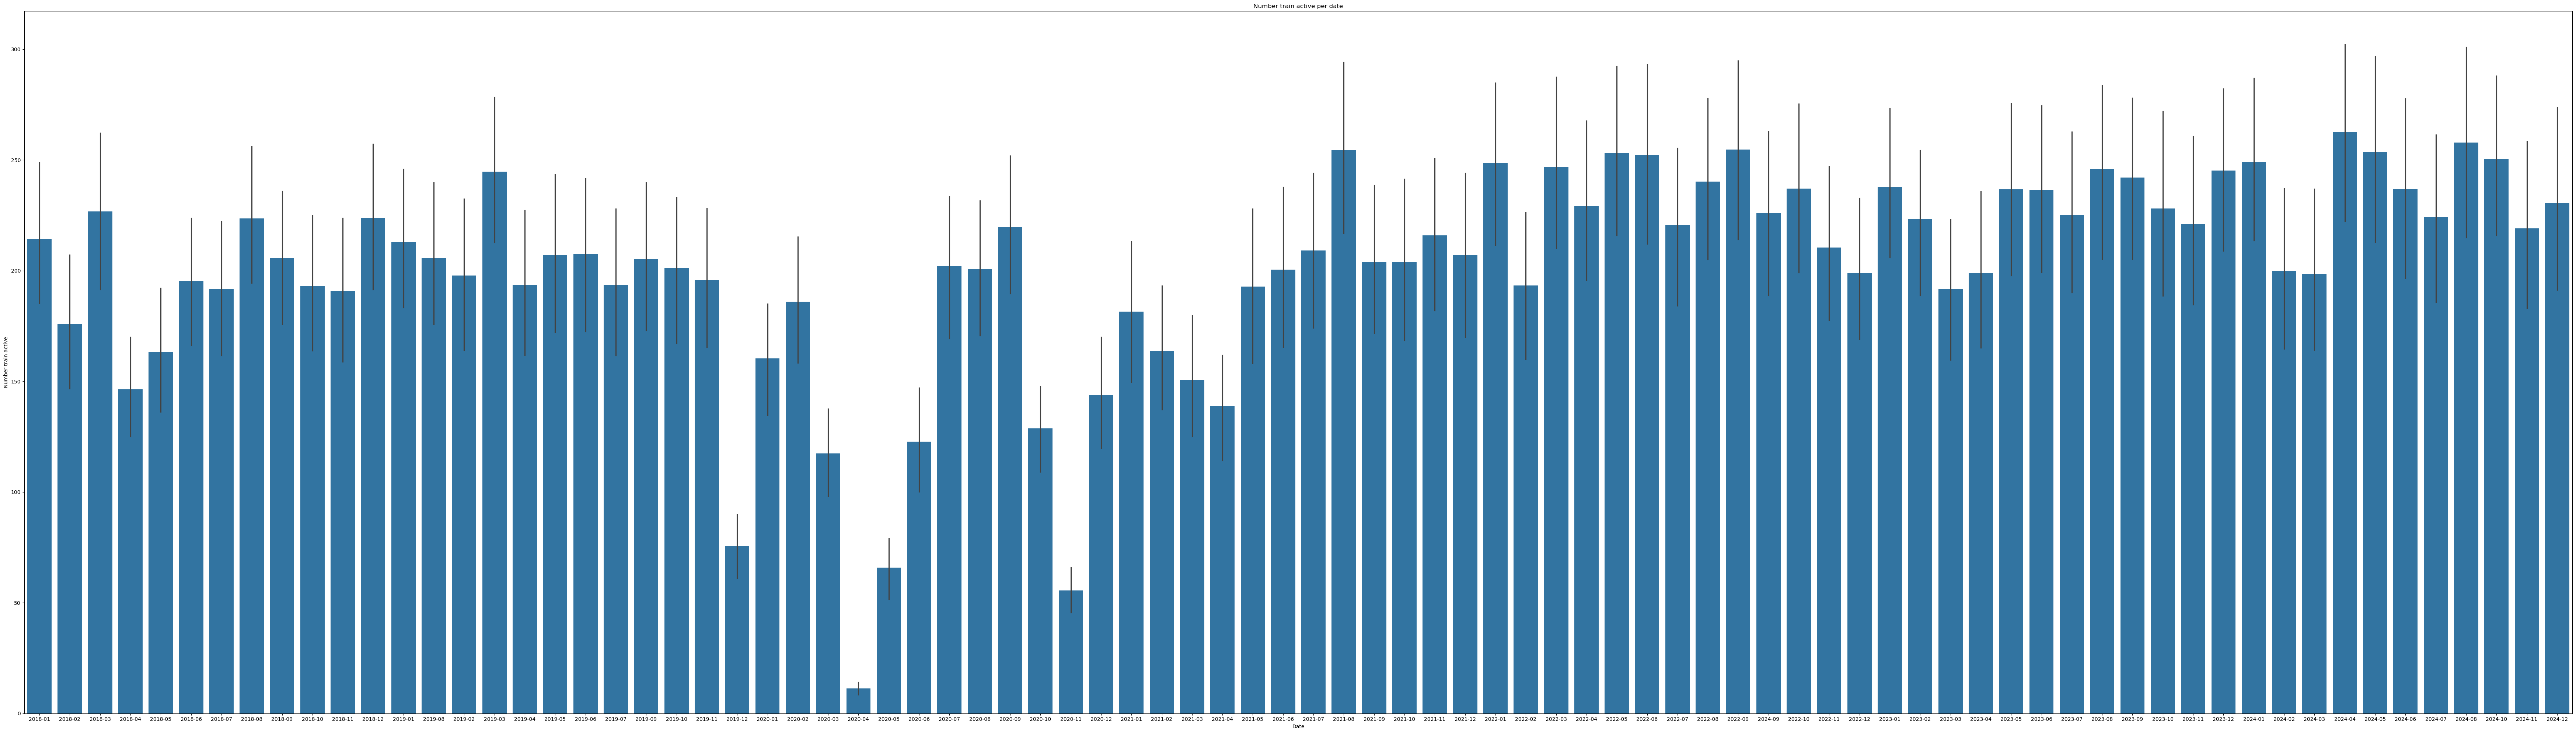

In [46]:
plt.figure(figsize=(70, 20))
sns.barplot(x="Date", y="Number train active", data=data_clean)
plt.title("Number train active per date")
plt.tight_layout()
plt.show()

# Correlation map of numerical variables

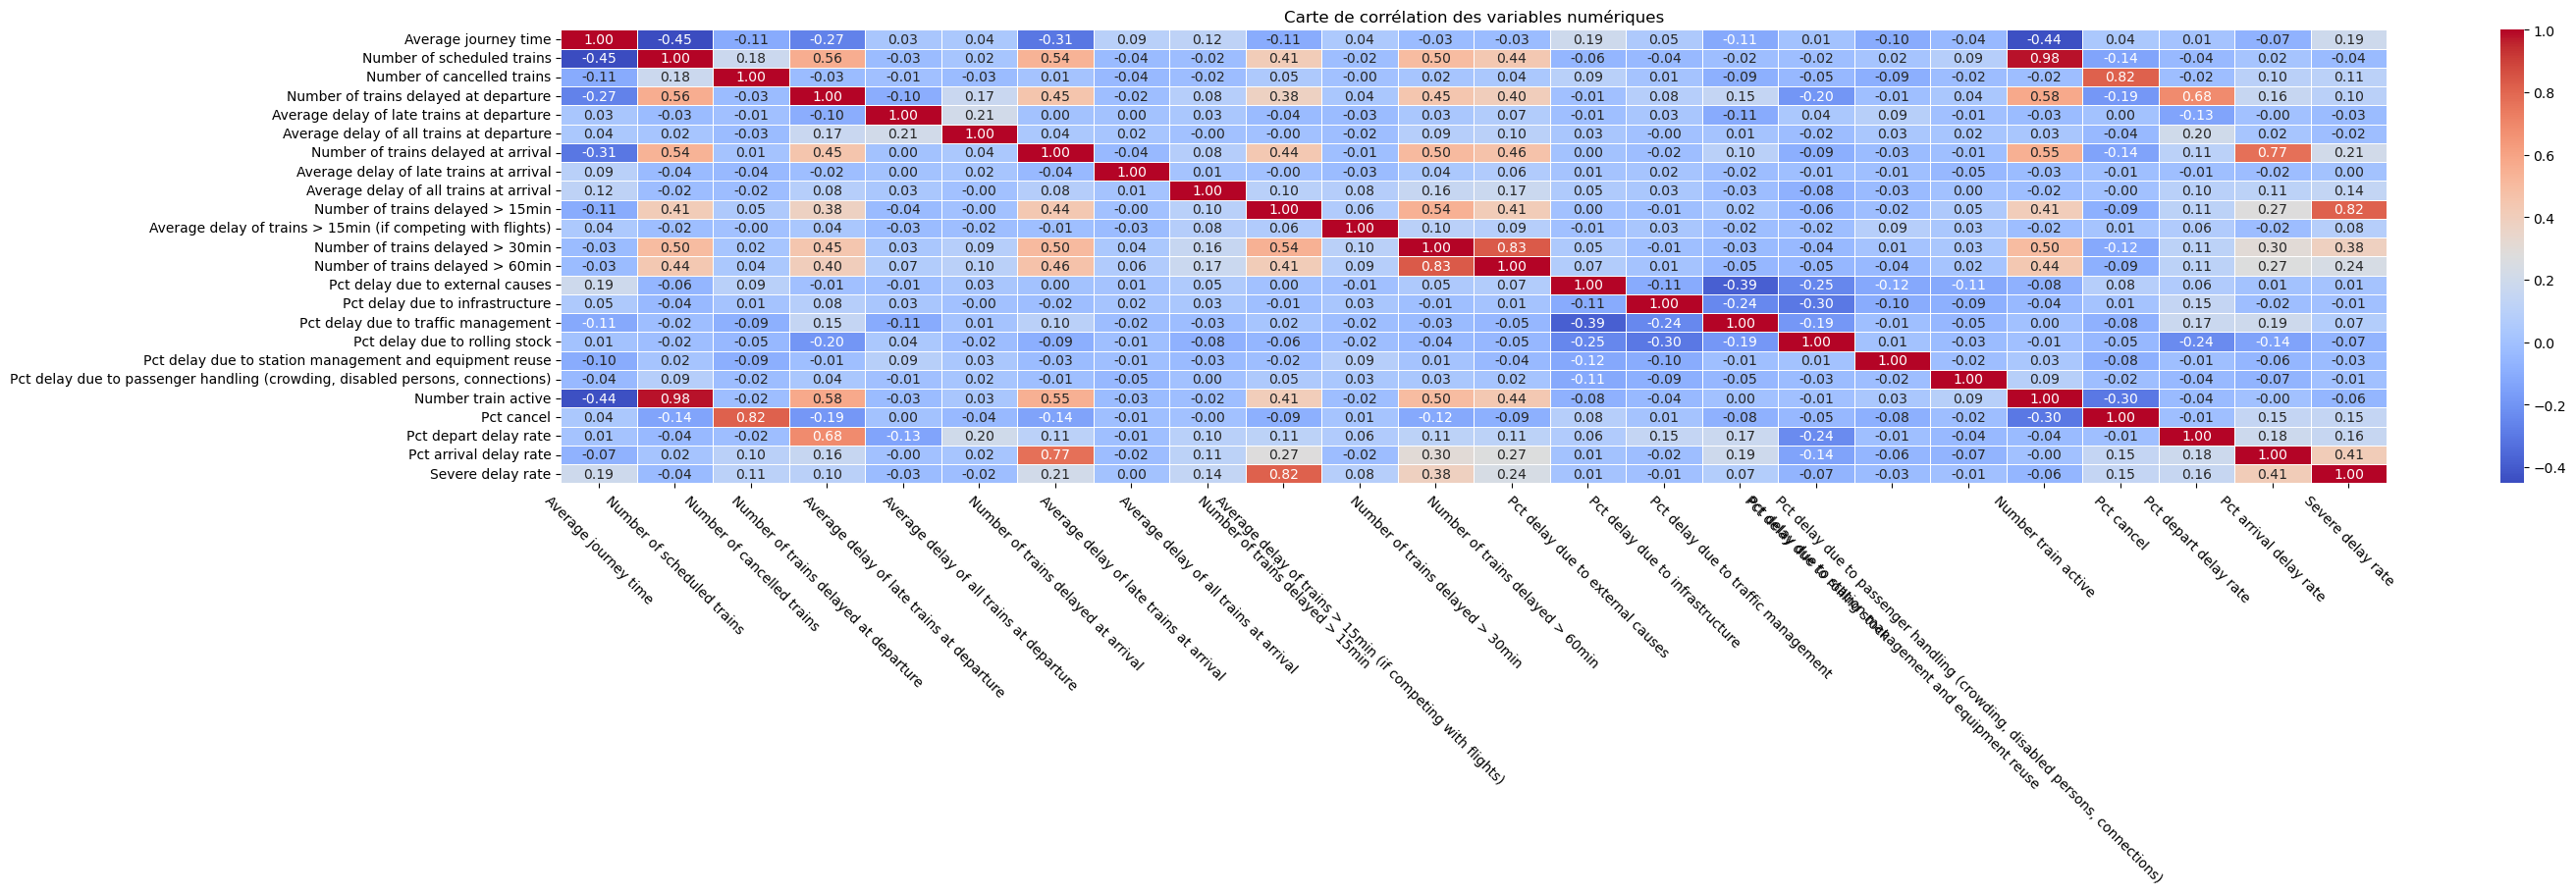

In [47]:
plt.figure(figsize=(30,6))
numeric_cols = data_clean.select_dtypes(include='number').columns
data_clean_filtered = data_clean[(data_clean[numeric_cols] >= 0).all(axis=1)].copy()
correlation_matrix = data_clean_filtered.corr(numeric_only=True)
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Carte de corrélation des variables numériques")
plt.xticks(rotation=-45)
plt.show()

# Average causes of delays

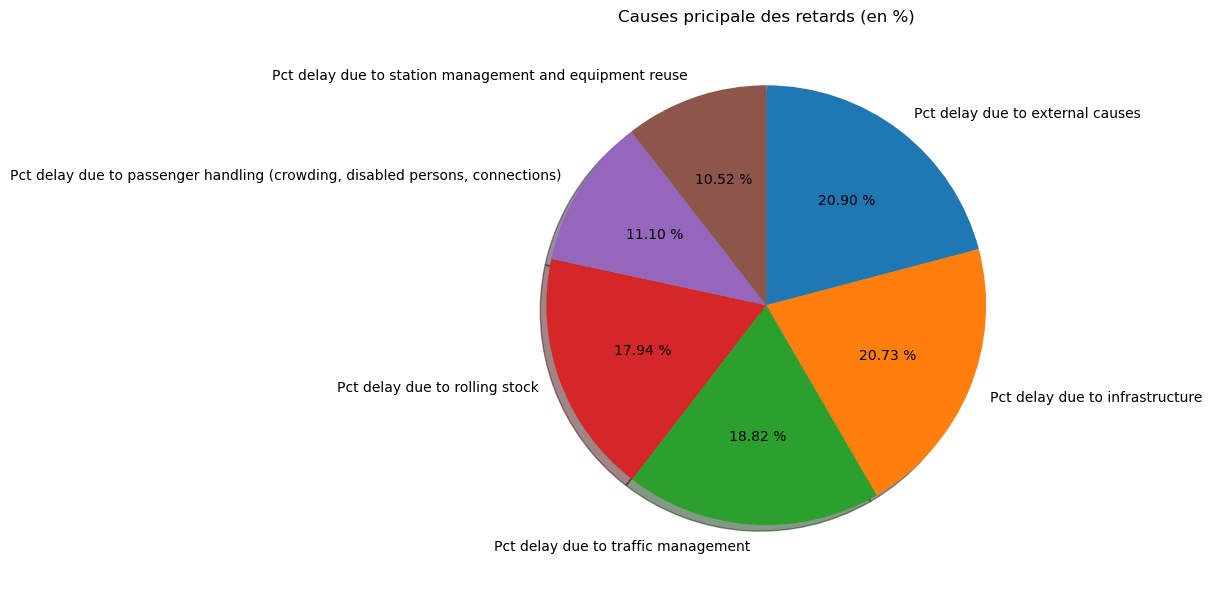

In [48]:
cause_cols = [
    "Pct delay due to external causes",
    "Pct delay due to infrastructure",
    "Pct delay due to traffic management",
    "Pct delay due to rolling stock",
    "Pct delay due to station management and equipment reuse",
    "Pct delay due to passenger handling (crowding, disabled persons, connections)"
]

cause_means = data_clean[cause_cols].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.pie(cause_means.values, labels=cause_means.index, autopct='%.2f %%', shadow=True, startangle=90, counterclock=False)
plt.title("Causes pricipale des retards (en %)")
plt.tight_layout()
plt.show()

# Histogram of Scheduled Trains

This histogram shows the distribution of the number of scheduled trains. The x-axis represents the number of scheduled trains per station or period (depending on the dataset structure), while the y-axis indicates how frequently each value occurs.

The red bars illustrate how often certain train frequencies appear in the dataset, helping identify common scheduling patterns or detect any anomalies (e.g., stations with unusually low or high numbers of scheduled trains).


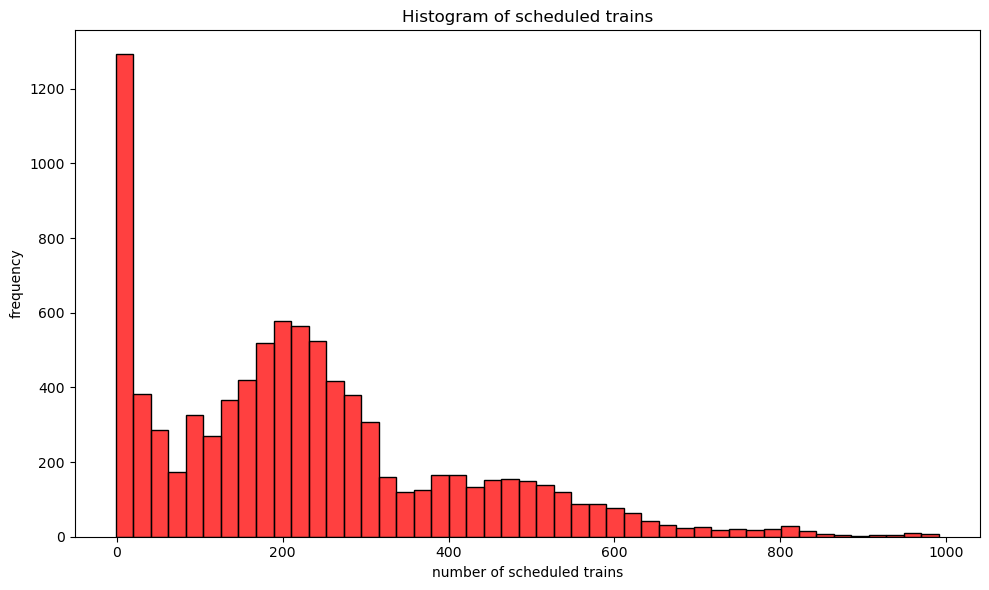

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(data_clean["Number of scheduled trains"], kde=False, color='red')
plt.title("Histogram of scheduled trains")
plt.xlabel("number of scheduled trains")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()


### Top 10 Stations with the Highest Average Departure Delays

This bar chart displays the **top 10 train departure stations** whose trains experience the **highest average delay upon departure**. Only records with a **positive arrival delay** are considered to ensure data accuracy.

- The x-axis represents the **average arrival delay** (in minutes).
- The y-axis lists the **stations of departure**.

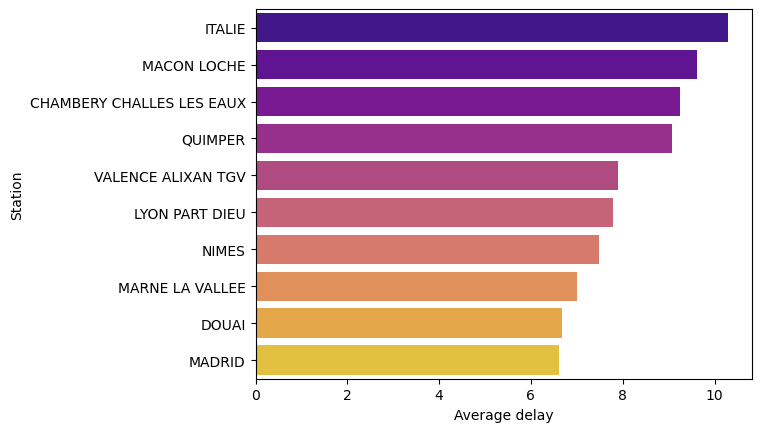

In [50]:
data_valid_delay = data_clean[data_clean["Average delay of all trains at departure"] > 0]
delay_by_station = data_valid_delay.groupby("Departure station")["Average delay of all trains at departure"].mean().sort_values(ascending=False).head(10)
fig, ax = plt.subplots()
data_delay = delay_by_station.reset_index()
sns.barplot(data=data_delay,x="Average delay of all trains at departure", y="Departure station", hue="Departure station", palette="plasma", dodge=False, legend=False, ax=ax)
ax.set_xlabel("Average delay")
ax.set_ylabel("Station")
plt.show()

### Top 10 Stations with the Highest Average Arrival Delays

This bar chart displays the **top 10 train departure stations** whose trains experience the **highest average delay upon arrival**. Only records with a **positive arrival delay** are considered to ensure data accuracy.

- The x-axis represents the **average arrival delay** (in minutes).
- The y-axis lists the **stations of departure**.

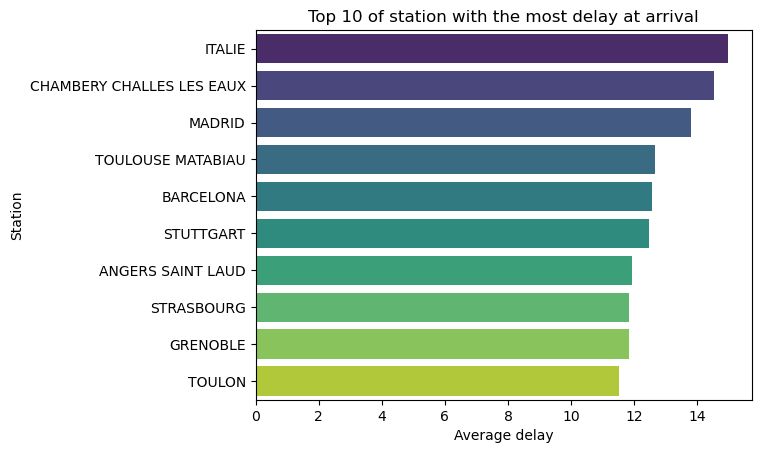

In [51]:
data_valid_delay = data_clean[data_clean["Average delay of all trains at arrival"] > 0]
delay_by_station = data_valid_delay.groupby("Departure station")["Average delay of all trains at arrival"].mean().sort_values(ascending=False).head(10)
fig, ax = plt.subplots()
data_delay = delay_by_station.reset_index()
sns.barplot(data=data_delay,x="Average delay of all trains at arrival", y="Departure station", hue="Departure station", palette="viridis", dodge=False, legend=False, ax=ax)
ax.set_title("Top 10 of station with the most delay at arrival")
ax.set_xlabel("Average delay")
ax.set_ylabel("Station")
plt.show()